In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import time
import datetime

from metamux.dataset.dataset import Dataset
from metamux.classification.training_data import TrainingDataLoader
from metamux.classification import defaults, training_data_filter
from metamux.classification.features import peak_detection, smoothing, util, statistics, channel_select, differential
from metamux.classification.plot_cm import plot_cm
from metamux.classification.features import feature_selection
from metamux.classification import segment_feature_union

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from metamux.classification.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, cross_validate, LeaveOneOut, LeaveOneGroupOut, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer, StandardScaler

import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns

#from IPython.display import display

import Decoder # Preprocessor from JP

# to get dir_paths from final recordings
from os import listdir
from os.path import isfile, join

from plot_cm import plot_cm # Confusion Matrix from JH

from tools import make_name, save_infos

from rename_labels import label_dict # dict with names for labels (Schrauben, Stift rein,...)
from rename_labels import get_opposites_out, merge_variants_screw_lr, merge_variants_screw_abc
import recordings_paths # for filling DataLoader
from plot_data import plot_slot, make_cm_all, make_cm_tt # to plot line-plots and cm_plot from JH
from data_prep import prep_data, select_sensor_channel

In [2]:
# 'JP10, MM, CA, AR, MJ, JH, CD'
# 'JP10, MM, AR, MJ, CD'
# JP05
# all10

subjects = 'JP10'
#.split(', ') # nicht hier splitten, all und all10 wird noch ersetzt und dann gesplittet

sensors_lists = ['dist pos'.split(), 'acc gyro'.split(), 'dist pos acc gyro'.split(), 'pos acc gyro'.split()]
sensors_list = sensors_lists[0]

merge_opposites = False # rename to with_opp? <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
merge_screw_lr = False
merge_screw_abc = False

fuse_slots = None
#fuse_slots = [[210, 310], [240, 340], [250, 350]]
#fuse_slots = [[210, 310], [230, 330], [235, 335]]
#fuse_slots = [[210, 310], [220, 320], [225, 325]]

In [3]:
slot_filling=False
name=None

In [4]:
subjects=subjects
sensors_list=sensors_list

fuse_slots=fuse_slots

merge_opposites=merge_opposites
merge_screw_lr=merge_screw_lr
merge_screw_abc=merge_screw_abc

show_time=False
show_dots=False
debug=False
deep_debug=False

In [5]:
###################################################
#                                                 #
#                   PIPELINE                      #
#                                                 #
###################################################

def np_flatten(ar):
    return ar.flatten()

# TODO füllen von Pipeline dynamisch machen? bools übergeben und dann entsprechend dazunehmen?

# ACC + GYRO
pipe_all = Pipeline([
    # ('ch_imu', channel_select.SegmentChannelSelectionTransformer(range(0, 6))),
    # von JH für Selektion zwischen IMU und Myo
    ('differential', segment_feature_union.SegmentFeatureUnion([
        ('identity', util.SegmentFunctionTransformer()),
        # ('diff', differential.SegmentDiffTransformer()),
        # ('int1', differential.SegmentIntTransformer()),
        # ('int2', differential.SegmentInt2Transformer()),
    ])),
    ('features', FeatureUnion([
        ('min', util.SegmentFunctionTransformer(np.amin, {'axis': 0})),
        ('max', util.SegmentFunctionTransformer(np.amax, {'axis': 0})),
        ('mean', util.SegmentFunctionTransformer(np.mean, {'axis': 0})),
        # ('med', util.SegmentFunctionTransformer(np.median, {'axis': 0})),
        # ('rms', statistics.SegmentRMSTransformer()),
        # ('std', util.SegmentFunctionTransformer(np.std, {'axis': 0})),
        # ('var', util.SegmentFunctionTransformer(np.var, {'axis': 0})),
        # ('q25', statistics.SegmentQuantilesTransformer(percentiles=[25])),
        # ('q75', statistics.SegmentQuantilesTransformer(percentiles=[75])),
        # ('zcc', statistics.SegmentZCCTransformer(offset=500)),
        # ('skew', util.SegmentFunctionTransformer(scipy.stats.skew)),
        # ('kurt', util.SegmentFunctionTransformer(scipy.stats.kurtosis)),
    ]))
])

# TODO Klassifikator auch ausgeben!! ------------------------------------------------------------

diff_features = pipe_all.steps[0][1].transformer_list
diff_features_list = [diff_feature[0] for diff_feature in diff_features]

stat_features = pipe_all.steps[1][1].transformer_list
stat_features_list = [stat_feature[0] for stat_feature in stat_features]

pipe = Pipeline([
    ('features', FeatureUnion([
        ('pipe_all', pipe_all)
        # ('pipe_imu', pipe_imu),
        # ('pipe_fsr', pipe_fsr),
    ])),
    ('flattening', util.SegmentFunctionTransformer(np_flatten)),
    # ('standardscaler', StandardScaler()), # Either LDA or StandardScaler is required
    # ('normalizer', Normablizer()), # Bad idea TODO why? (NormaBBBlizer? oder Normalizer? ist doch Tippfehler!?
    # ('pca', PCA()), #n_components=15)),
    # ('te', TestEstimator()),
    ('lda', LinearDiscriminantAnalysis()),
    # ('lda', LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')),# JH special lda
    # ('svm', SVC(C=1000, gamma=0.001, probability=True, kernel='rbf')),
    # ('rf', RandomForestClassifier(n_estimators=100, max_features='auto')),
])

In [6]:
subjects

'JP10'

In [7]:
###################################################
#                                                 #
#                  PREP DATA                      #
#                                                 #
###################################################

prep_start_time = datetime.datetime.now()

if debug: print('got name {}'.format(name))

if name is None:
    name = make_name(subjects=subjects, sensors_list=sensors_list,
                     diff_features_list=diff_features_list, stat_features_list=stat_features_list,
                     fuse_slots=fuse_slots,
                     merge_opposites=merge_opposites,
                     merge_screw_lr=merge_screw_lr, merge_screw_abc=merge_screw_abc,
                     show_time=show_time, show_dots=show_dots, debug=debug, deep_debug=deep_debug)
if debug: print('name = {}'.format(name))

loader = recordings_paths.fill_loader(debug=debug)

if subjects == 'all':
    subjects = 'JP10,MM,AR,MJ,CA,CD,JH10'
elif subjects == 'all10':
    subjects = 'JP10,MM,AR,MJ,CD,JH10'
subjects = subjects.split(',')  # making list with subjects names

path_list = loader.get_data(subjects, debug=debug, deep_debug=deep_debug)  # get paths for subjects

In [8]:
subjects

['JP10']

In [9]:
subject_list = subjects
time = False
debug = False
deep_debug = False


# TODO vorerst nur mal path_lists zurückgeben, damit selbst data abholen
# TODO --> direkt hier data abholen und gleich weitergeben TODO!!!

if debug: print('getting data of subjects {}'.format(subject_list))

bool_all = subject_list == None # TODO wenn keine subject_list, dann alle hergeben
if debug: print('give all rec_paths? - {}'.format(bool_all))

subjects_paths = []

if bool_all:
    # TODO direkt hier Erstellen von Path_list und return, gar nicht runter gehen kompliziert in Schleife rein
    subjects_paths = [path for subject_tup in self.subject_tups for path in subject_tup[1]]
    print(subjects_paths) 

if debug: print('subject_list = {}'.format(subject_list))

In [10]:
subject_list

['JP10']

In [11]:
for subject_tup in loader.subject_tups:
    if deep_debug: print('checking {}'.format(subject_tup[0]), end='')
    if deep_debug: print(' for {} - {}'.format(subject_list, type(subject_list)))

    if subject_tup[0] in subject_list:
        print('check subject {}'.format(subject_tup[0]))
        for path in subject_tup[1]:
            subjects_paths.append(path)
        # subjects_paths.append(subject_tup[1])
        if debug: print('giving out subject_tup {}'.format(subject_tup[0]))
print(subjects_paths)

check subject JP10
['sample-20190301-224533-JP2', 'sample-20190301-225705-JP2', 'sample-20190301-230815-JP2', 'sample-20190301-231740-JP2', 'sample-20190301-223845-JP2', 'sample-20190302-153652-JP2', 'sample-20190302-155156-JP3', 'sample-20190302-160011-JP3', 'sample-20190302-160654-JP3', 'sample-20190302-161609-JP3']


In [12]:
path_list

['sample-20190301-224533-JP2',
 'sample-20190301-225705-JP2',
 'sample-20190301-230815-JP2',
 'sample-20190301-231740-JP2',
 'sample-20190301-223845-JP2',
 'sample-20190302-153652-JP2',
 'sample-20190302-155156-JP3',
 'sample-20190302-160011-JP3',
 'sample-20190302-160654-JP3',
 'sample-20190302-161609-JP3']

In [13]:
len(path_list)

10

In [14]:
show_time=True
show_dots=True
debug=True
deep_debug=True

In [15]:
###################################################
#                                                 #
#                   GET DATA                      #
#                                                 #
###################################################

# data und targets für subject und sensors_list holen
sessions, targets, concat_data, concat_targets, worked_with = prep_data(path_list=path_list, sensors_list=None, 
                                                                        fuse_slots=fuse_slots, slot_filling=slot_filling, 
                                                                        show_time=show_time, show_dots=show_dots, 
                                                                        debug=debug, deep_debug=deep_debug)

# gewünsche Sensorkanäle aus sessions holen
sessions = select_sensor_channel(sessions, sensors_list, show_time=show_time, show_dots=show_dots, 
                                 debug=debug, deep_debug=deep_debug)

# data in eine liste
all_data = [slots.values for session in sessions for slots in session]

# get labels out
if not merge_opposites:
    # concat_targets_noopp = [get_opposites_out[l] for l in concat_targets]
    concat_targets = [get_opposites_out[l] for l in concat_targets]
    if debug: print('get opposites out')
if merge_screw_lr:
    #concat_targets_abc = [merge_variants_screw_lr[l] for l in concat_targets]
    concat_targets = [merge_variants_screw_lr[l] for l in concat_targets]
    if debug: print('merge lr screwing')
if merge_screw_abc:
    #concat_targets_lr = [merge_variants_screw_abc[l] for l in concat_targets]
    concat_targets = [merge_variants_screw_abc[l] for l in concat_targets] # TODO ------------------------------------------------------------------ auch für do_it_ud!!!!!!
    if debug: print('merge abc screwing')

prep_end_time = datetime.datetime.now()

prep_end_time = datetime.datetime.now()
pred_start_time = datetime.datetime.now()

Start time = 2019-05-29 14:05:20.489143
took default sensors_list
-getting data for 10 paths

making session: sample-20190301-224533-JP2
.
making session: sample-20190301-225705-JP2
.
making session: sample-20190301-230815-JP2
.
making session: sample-20190301-231740-JP2
.
making session: sample-20190301-223845-JP2
.
making session: sample-20190302-153652-JP2
.
making session: sample-20190302-155156-JP3
.
making session: sample-20190302-160011-JP3
.
making session: sample-20190302-160654-JP3
.
making session: sample-20190302-161609-JP3
. done, 0:00:05.603040
-deleting counter .......... done, 0:00:00.125622
-concat data      done, 0:00:00.004986
-concat targets   .......... done, 0:00:00.008012

data prep duration = 0:00:05.742673

sessions = list of all sessions, 1 session = list of all slots, 1 slot = dataframe with data between timestamp borders
all_targets = list of all targets (from all sessions), 1 targets_list = dataframe with targets = ground truths = Y
concat_data = sessions c

In [16]:
###################################################
#                                                 #
#                   PIPELINE                      #
#                                                 #
###################################################

def np_flatten(ar):
    return ar.flatten()

# TODO füllen von Pipeline dynamisch machen? bools übergeben und dann entsprechend dazunehmen?

# ACC + GYRO
pipe_all = Pipeline([
    # ('ch_imu', channel_select.SegmentChannelSelectionTransformer(range(0, 6))),
    # von JH für Selektion zwischen IMU und Myo
    ('differential', segment_feature_union.SegmentFeatureUnion([
        ('identity', util.SegmentFunctionTransformer()),
        ('diff', differential.SegmentDiffTransformer()),
        ('int1', differential.SegmentIntTransformer()),
        # ('int2', differential.SegmentInt2Transformer()),
    ])),
    ('features', FeatureUnion([
        ('min', util.SegmentFunctionTransformer(np.amin, {'axis': 0})),
        ('max', util.SegmentFunctionTransformer(np.amax, {'axis': 0})),
        ('mean', util.SegmentFunctionTransformer(np.mean, {'axis': 0})),
        # ('med', util.SegmentFunctionTransformer(np.median, {'axis': 0})),
        # ('rms', statistics.SegmentRMSTransformer()),
        # ('std', util.SegmentFunctionTransformer(np.std, {'axis': 0})),
        # ('var', util.SegmentFunctionTransformer(np.var, {'axis': 0})),
        # ('q25', statistics.SegmentQuantilesTransformer(percentiles=[25])),
        # ('q75', statistics.SegmentQuantilesTransformer(percentiles=[75])),
        # ('zcc', statistics.SegmentZCCTransformer(offset=500)),
        # ('skew', util.SegmentFunctionTransformer(scipy.stats.skew)),
        # ('kurt', util.SegmentFunctionTransformer(scipy.stats.kurtosis)),
    ]))
])

# TODO Klassifikator auch ausgeben!! ------------------------------------------------------------

diff_features = pipe_all.steps[0][1].transformer_list
diff_features_list = [diff_feature[0] for diff_feature in diff_features]

stat_features = pipe_all.steps[1][1].transformer_list
stat_features_list = [stat_feature[0] for stat_feature in stat_features]

pipe = Pipeline([
    ('features', FeatureUnion([
        ('pipe_all', pipe_all)
        # ('pipe_imu', pipe_imu),
        # ('pipe_fsr', pipe_fsr),
    ])),
    ('flattening', util.SegmentFunctionTransformer(np_flatten)),
    # ('standardscaler', StandardScaler()), # Either LDA or StandardScaler is required
    # ('normalizer', Normablizer()), # Bad idea TODO why? (NormaBBBlizer? oder Normalizer? ist doch Tippfehler!?
    # ('pca', PCA()), #n_components=15)),
    # ('te', TestEstimator()),
    ('lda', LinearDiscriminantAnalysis()),
    # ('lda', LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')),# JH special lda
    # ('svm', SVC(C=1000, gamma=0.001, probability=True, kernel='rbf')),
    # ('rf', RandomForestClassifier(n_estimators=100, max_features='auto')),
])

In [17]:
###################################################
#                                                 #
#                CLASSIFICATION                   #
#                                                 #
###################################################

# train and test
predicted = cross_val_predict(pipe, all_data, concat_targets, cv=LeaveOneOut())

pred_end_time = datetime.datetime.now()
draw_start_time = datetime.datetime.now()

# num_sessions = len(path_list) # TODO make auto toggle!!!
num_sessions = worked_with

Analysed sensors: , dist, pos
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 10
Subjects = , JP10


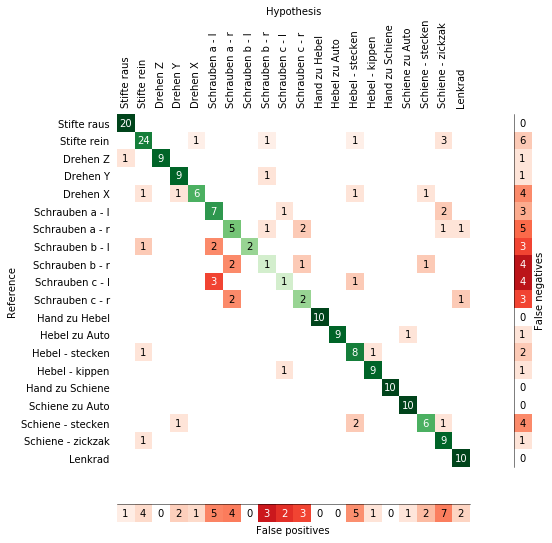

Accuracy = 79.52380952380952
Mode =  no_opp
---train_subjects = None
[2, 3, 7, 8, 23, 24, 28, 29, 44, 45, 49, 50, 65, 66, 70, 71, 86, 87, 91, 92, 107, 108, 112, 113, 128, 129, 133, 134, 149, 150, 154, 155, 170, 171, 175, 176, 191, 192, 196, 197]
[110, 330, 110, 111, 130, 111, 130, 121, 110, 131, 110, 111, 340, 111, 110, 111, 110, 121, 230, 340, 110, 131, 110, 131, 120, 111, 110, 111, 120, 131, 110, 131, 110, 111, 110, 111, 20, 410, 340, 410]
[110, 121, 130, 111, 110, 121, 130, 111, 110, 121, 130, 111, 110, 121, 130, 111, 110, 121, 130, 111, 120, 111, 110, 131, 120, 111, 110, 131, 120, 111, 110, 131, 120, 111, 110, 131, 120, 111, 110, 131]
45.0
45.0
preparation duration = 0:00:06.545480
prediciton duration  = 0:00:04.508940
drawing duration     = 0:00:03.242339


<Figure size 432x288 with 0 Axes>

In [18]:
###################################################
#                                                 #
#                 SHOW RESULTS                    #
#                                                 #
###################################################

mode = ''
if not merge_opposites:
    mode = mode + ' no_opp'
if merge_screw_lr:
    mode = mode + ' abc'
if merge_screw_abc:
    mode = mode + '  lr'
if fuse_slots is not None:
    mode = mode + ' ' + str(fuse_slots[2])

# plot cm
make_cm_all(sensors_list, diff_features_list, stat_features_list, worked_with, subjects, concat_targets, predicted,
            label_dict, mode, name)

save_infos(sensors_list=sensors_list, diff_features_list=diff_features_list, stat_features_list=stat_features_list,
           path_list=worked_with, subjects=subjects,
           targets=concat_targets, predicted=predicted,
           rename=label_dict, mode=mode, name=name)

draw_end_time = datetime.datetime.now()

print('preparation duration = {}'.format(prep_end_time - prep_start_time))
print('prediciton duration  = {}'.format(pred_end_time - pred_start_time))
print('drawing duration     = {}'.format(draw_end_time - draw_start_time))

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from plot_cm import remove_chartjunk # Confusion Matrix from JH

def plot_cm_jo(y_true,
            y_pred,
            order=None,
            rename=None,
            hypo_names_rotation='vertical',
            hypo_names_above=True,
            textsize_values=None,
            textsize_labels=None,
            textsize_expl=None,
            lang='en',
            plotlegend=False,
            diag_color=True,
            fig_width=8.5,
            name='test'):
    """
    Compute a confusion matrix and plot it.

    :param y_true: list or 1D-np.array of true labels
    :param y_pred: list or 1D-np.array of predicted labels. Must be of same length as y_true.
    :param order: Optional: list of the class labels used in y_true and y_pred. May be used to order the labels or select a subset.
    :param rename: Optional: A dict mapping class labels used in y_true and y_pred to new names that will be displayed instead.
    :param hypo_names_rotation: 'vertical' or 'horizontal' to select rotation of hypothesis labels
    :param hypo_names_above: if True, show hypothesis labels above the plot instead of below
    :param textsize_values: textsize of values in the matrix
    :param textsize_labels: textsize of the class names labeling the rows/columns
    :param textsize_expl: textsize of explanations ('Hypothesis', 'False positives', ...)
    :param lang: language of explanations. 'en' or 'de'
    :param plotlegend: if True, plot the colormap legend.
    :param diag_color: if True, paint the main diagonal (correct classifications) in a different color
    :param fig_width: width of figure (height is selected by fixed aspect ratio)
    :param name: name to save plot under
    :return: 
    """

    fig_aspect = 7.5 / 8.5
    figsize = (fig_width, fig_width * fig_aspect)

    labeldict = {
        'hypothesis': {'de': 'Hypothese', 'en': 'Hypothesis'},
        'reference': {'de': 'Referenz', 'en': 'Reference'},
        'falsepos': {'de': 'Falsch-positive', 'en': 'False positives'},
        'falseneg': {'de': 'Falsch-negative', 'en': 'False negatives'}
    }

    if order is None:
        order = unique_labels(y_true, y_pred)

    if rename is None:
        label_names = order
    else:
        label_names = [rename[l] for l in order]

    conf_arr = confusion_matrix(y_true, y_pred, order)

    dim = len(conf_arr)
    conf_arr_no_diag = np.copy(conf_arr)
    np.fill_diagonal(conf_arr_no_diag, 0)

    with np.errstate(invalid='ignore'):  # ignore warnings due to NaN
        norm_conf = (conf_arr.astype(np.float) / conf_arr.sum(axis=1)[:, np.newaxis])

        false_negatives_nn = np.sum(conf_arr_no_diag, axis=1)  # false negatives per row
        false_negatives = (false_negatives_nn.astype(np.float) / np.sum(conf_arr, axis=1)).reshape(1, (
            -1))  # false negatives per line / all per line

        false_positives_nn = np.sum(conf_arr_no_diag, axis=0)  # false positives per column
        false_positives = (false_positives_nn.astype(np.float) / np.sum(conf_arr, axis=0)).reshape(1, (
            -1))  # false positives per column / all per column

    fig = plt.figure(figsize=figsize)
    plt.clf()

    reds = plt.cm.Reds
    reds.set_under('white')
    greens = plt.cm.Greens
    greens.set_under('white')
    reds.set_bad('white')  # kind of useless, why would there be masked values in the confmatrix?

    gs = grd.GridSpec(2, 3, height_ratios=[dim, 1], width_ratios=[dim, 1, 0.8], wspace=0.15, hspace=0.2)
    ax = fig.add_subplot(gs[0])
    ax.set_aspect('equal')
    res = ax.imshow(norm_conf, cmap=reds, vmin=0.001, vmax=1)  # interpolation='nearest' does nothing

    if diag_color:  # plot correct values green
        diag = np.diag(np.diag(norm_conf))
        with np.errstate(invalid='ignore'):  # ignore warnings due to NaN
            diag_masked = np.ma.masked_array(diag, diag <= 0)
        res2 = ax.imshow(diag_masked, cmap=greens, vmin=0.001, vmax=1)  # interpolation='nearest' does nothing


    plt.xlabel(labeldict['hypothesis'][lang], size=textsize_expl)
    if hypo_names_above:
        ax.xaxis.set_label_position('top')  # move 'Hypothesis' label to top
    plt.ylabel(labeldict['reference'][lang], size=textsize_expl)

    # numbers (only if not zero)
    for x in range(dim):
        for y in range(dim):
            if norm_conf[x][y] > 0:
                ax.annotate(str(conf_arr[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',
                            color='w' if norm_conf[x][y] > 0.5 else 'k',
                            size=textsize_values)

    # class labels
    # plt.xticks(range(dim), order[:dim], rotation=hypo_names_rotation, size=textsize_labels)
    plt.xticks(range(dim), label_names, rotation=hypo_names_rotation, size=textsize_labels)
    if hypo_names_above:
        ax.xaxis.tick_top()  # move hypothesis class names to top
    # plt.yticks(range(dim), order[:dim], size=textsize_labels)
    plt.yticks(range(dim), label_names, size=textsize_labels)
    
    remove_chartjunk(ax, ['top', 'right', 'left', 'bottom'])  # removes ticks and border (second arg)
    # bar on the right with false negatives
    #ax_neg = fig.add_subplot(gs[1])
    
    #res_neg = ax_neg.imshow(false_negatives.T, cmap=reds,
    #                        interpolation="nearest", vmin=0.001, vmax=1)
    #remove_chartjunk(ax_neg, ['top', 'right', 'bottom'])
    #
    #for x in range(dim):
    #    ax_neg.annotate(str(false_negatives_nn[x]), xy=(0, x),
    #                    horizontalalignment='center',
    #                    verticalalignment='center',
    #                    color='w' if false_negatives[0][x] > 0.5 else 'k',
    #                    size=textsize_values)
    #plt.xticks([])
    #plt.yticks([])
    #label 'false negatives'
    #ax_neg.yaxis.set_label_position("right")
    #ax_neg.set_ylabel(labeldict['falseneg'][lang], size=textsize_expl)
    #
    ## bar on the bottom with false positives
    #ax_pos = fig.add_subplot(gs[3])
    #res_pos = ax_pos.imshow(false_positives, cmap=reds,
    #                        interpolation="nearest", vmin=0.001, vmax=1)
    #remove_chartjunk(ax_pos, ['left', 'right', 'bottom'])
    
    #for x in range(dim):
    #    ax_pos.annotate(str(false_positives_nn[x]), xy=(x, 0),
    #                    horizontalalignment='center',
    #                    verticalalignment='center',
    #                    color='w' if false_positives[0][x] > 0.5 else 'k',
    #                    size=textsize_values)
    #
    #plt.xticks([])
    #plt.yticks([])
    
    # label 'false positives'
    #ax_pos.set_xlabel(labeldict['falsepos'][lang], size=textsize_expl)

    if plotlegend:
        ax_clrbr = fig.add_subplot(gs[:, -1])
        cb = fig.colorbar(res, cax=ax_clrbr)

    # bbox_inches = "tight" needed to not cut off xlabels
    plt.savefig(name + ".svg", format="svg", bbox_inches = "tight")
    plt.savefig(name + ".png", format="png", bbox_inches = "tight")
    plt.savefig(name + ".pdf", format="pdf", bbox_inches = "tight")

    plt.show()  # J: show needed here because we clear the figure, fig needs to be cleared for barplot

    plt.clf()

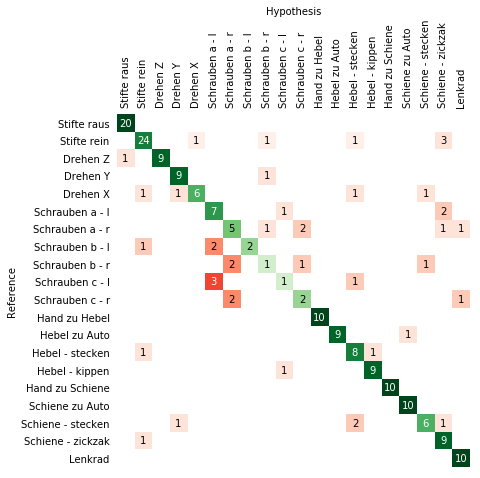

<Figure size 432x288 with 0 Axes>

In [51]:
plot_cm_jo(concat_targets, predicted, rename=label_dict, name=name)

In [20]:
from plot_data import plot_precisions

In [21]:
report = sklearn.metrics.classification_report(concat_targets, predicted)
acc = accuracy_score(concat_targets, predicted)*100
acc = round(acc, 2)
print('---------- acc = {}'.format(acc))
#plot_precisions(report, name=name, acc=acc)

---------- acc = 79.52


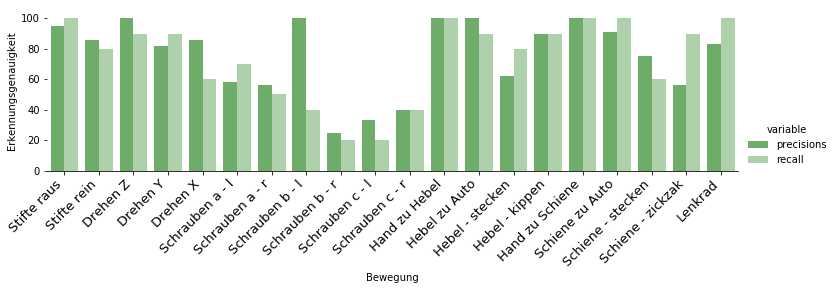

In [22]:
plot_precisions(report, 10, name=name, acc=acc, custom_color='#64b75f')

In [25]:
precisions[-1:]

NameError: name 'precisions' is not defined

In [ ]:
sum(precisions[:-1]) / len(precisions[:-1])

In [ ]:
accuracy_score(concat_targets, predicted)*100

In [ ]:
indices = ([i for i, x in enumerate(concat_targets) if x in [110, 111, 120, 121, 130, 131]])

In [ ]:
pred_schrauben = [x for i, x in enumerate(predicted) if i in indices] # select predicted with schrauben index

In [ ]:
targets_schrauben = ([x for i, x in enumerate(concat_targets) if i in indices])

In [ ]:
accuracy_score(targets_schrauben, pred_schrauben)*100

In [ ]:
schriftgroesse = 10
sns.set_context("paper", rc={"font.size":schriftgroesse,"axes.titlesize":schriftgroesse,"axes.labelsize":schriftgroesse})

In [ ]:
name='plots/asdf' + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # add time
debug=False

lines = report.split('\n')

classes = []
plotMat = []

# get precisions out of classification report
for line in lines[2: (len(lines) - 5)]:
    # print(line)
    t = line.split()
    # print('t = {}'.format(t))
    classes.append(t[0])  # t[0] = Class names
    v = [float(x) for x in t[1: len(t) - 1]]
    # print('v = {}'.format(v))
    plotMat.append(v)  # rest of t = (precision, recall, f1-score, support) values
    # precisions.append(t[1])

if debug: print(plotMat)
precisions = [elem[0] for elem in plotMat]
precisions = [elem * 100 for elem in precisions]
precisions = [round(elem, 2) for elem in precisions]
if debug: print(precisions)
recall = [elem[1] for elem in plotMat]
recall = [elem * 100 for elem in recall]
recall = [round(elem, 2) for elem in recall]
if debug: print(recall)

old_classes = classes
classes = [label_dict[int(item)] for item in classes]

raw_df = {'Bewegung': classes, 
            'precisions': precisions, 
            'recall': recall}
df = pd.DataFrame(raw_df, columns = ['Bewegung', 'precisions', 'recall'])
# precisions
df_melt = pd.melt(df, id_vars=['Bewegung'], value_vars=['precisions', 'recall'])

# Draw a nested barplot to show survival for class and sex
plt = sns.catplot(x="Bewegung", y="value", hue="variable", data=df_melt,
                height=3, aspect=3.5, kind="bar", palette=['#cf6d36', '#e8b89d'])

plt.set_xticklabels(classes, rotation=45, ha='right', size=13) # rename and position ticklabels

# plt.set_size_inches(15, 2)
plt.despine(left=True)
plt.set_ylabels("Erkennungsgenauigkeit")

In [ ]:
name

In [ ]:
plt.savefig(name + '_precisions' + ".svg", format="svg", bbox_inches="tight")
plt.savefig(name + '_precisions' + ".png", format="png", bbox_inches="tight")
plt.savefig(name + '_precisions' + ".pdf", format="pdf", bbox_inches="tight")

In [ ]:
plt = sns.barplot(x=classes, y=precisions, order=classes, palette="Blues_d")
plt.set_xticklabels(plt.get_xticklabels(), rotation=45, ha="right", size=schriftgroesse)
plt.figure.set_size_inches(15, 2)
plt.set_ylabel("Akkuratheit")
for index, row in enumerate(precisions):
    if debug: print('index = {}, class = {}, row = {}'.format(index, classes[index], row))
    plt.text(index, row, row, color='black', ha="center")

# Finalize the plot
sns.despine()  # remove the top and right spines from plot

fig = plt.get_figure()
# bbox_inches = "tight" needed to not cut off xlabels
fig.savefig(name + '_precisions' + ".svg", format="svg", bbox_inches="tight")
fig.savefig(name + '_precisions' + ".png", format="png", bbox_inches="tight")
fig.savefig(name + '_precisions' + ".pdf", format="pdf", bbox_inches="tight")

In [ ]:
raw_precisions = {'Subject': [1,2,3,4,5,6], 
            'kin': [79.52, 53.43, 69.52, 72.38, 65.24, 71.43], 
            'imu': [90.00, 88.24, 85.24, 82.38, 84.29, 92.38], 
            'fus-loo': [97.62, 92.16, 88.57, 91.43, 93.33, 91.9], 
            'fus-logo': [91.9, 77.45, 78.57, 86.19, 83.33, 91.43]}
precisions = pd.DataFrame(raw_precisions, columns = ['Subject', 'kin', 'imu', 'fus-loo'])
# precisions
precisions_melt = pd.melt(precisions, id_vars=['Subject'], value_vars=['kin', 'imu', 'fus-loo'])

# Draw a nested barplot to show survival for class and sex
plt = sns.catplot(x="Subject", y="value", hue="variable", data=precisions_melt,
                height=3, aspect=3, kind="bar", palette="muted")

# plt.set_size_inches(15, 2)
plt.despine(left=True)
plt.set_ylabels("Erkennungsgenauigkeit")

In [ ]:
###################################################
#                                                 #
#                   PIPELINE                      #
#                                                 #
###################################################

def np_flatten(ar):
    return ar.flatten()

# TODO füllen von Pipeline dynamisch machen? bools übergeben und dann entsprechend dazunehmen?

# ACC + GYRO
pipe_all = Pipeline([
    # ('ch_imu', channel_select.SegmentChannelSelectionTransformer(range(0, 6))),
    # von JH für Selektion zwischen IMU und Myo
    ('differential', segment_feature_union.SegmentFeatureUnion([
        ('identity', util.SegmentFunctionTransformer()),
        ('diff', differential.SegmentDiffTransformer()),
        ('int1', differential.SegmentIntTransformer()),
        # ('int2', differential.SegmentInt2Transformer()),
    ])),
    ('features', FeatureUnion([
        ('min', util.SegmentFunctionTransformer(np.amin, {'axis': 0})),
        ('max', util.SegmentFunctionTransformer(np.amax, {'axis': 0})),
        ('mean', util.SegmentFunctionTransformer(np.mean, {'axis': 0})),
        # ('med', util.SegmentFunctionTransformer(np.median, {'axis': 0})),
        # ('rms', statistics.SegmentRMSTransformer()),
        # ('std', util.SegmentFunctionTransformer(np.std, {'axis': 0})),
        # ('var', util.SegmentFunctionTransformer(np.var, {'axis': 0})),
        # ('q25', statistics.SegmentQuantilesTransformer(percentiles=[25])),
        # ('q75', statistics.SegmentQuantilesTransformer(percentiles=[75])),
        # ('zcc', statistics.SegmentZCCTransformer(offset=500)),
        # ('skew', util.SegmentFunctionTransformer(scipy.stats.skew)),
        # ('kurt', util.SegmentFunctionTransformer(scipy.stats.kurtosis)),
    ]))
])

# TODO Klassifikator auch ausgeben!! ------------------------------------------------------------

diff_features = pipe_all.steps[0][1].transformer_list
diff_features_list = [diff_feature[0] for diff_feature in diff_features]

stat_features = pipe_all.steps[1][1].transformer_list
stat_features_list = [stat_feature[0] for stat_feature in stat_features]

pipe = Pipeline([
    ('features', FeatureUnion([
        ('pipe_all', pipe_all)
        # ('pipe_imu', pipe_imu),
        # ('pipe_fsr', pipe_fsr),
    ])),
    ('flattening', util.SegmentFunctionTransformer(np_flatten)),
    # ('standardscaler', StandardScaler()), # Either LDA or StandardScaler is required
    # ('normalizer', Normablizer()), # Bad idea TODO why? (NormaBBBlizer? oder Normalizer? ist doch Tippfehler!?
    # ('pca', PCA()), #n_components=15)),
    # ('te', TestEstimator()),
    ('lda', LinearDiscriminantAnalysis()),
    # ('lda', LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')),# JH special lda
    # ('svm', SVC(C=1000, gamma=0.001, probability=True, kernel='rbf')),
    # ('rf', RandomForestClassifier(n_estimators=100, max_features='auto')),
])

In [ ]:
diff_features = pipe_all.steps[0][1].transformer_list
diff_features_list = [diff_feature[0] for diff_feature in diff_features]

stat_features = pipe_all.steps[1][1].transformer_list
stat_features_list = [stat_feature[0] for stat_feature in stat_features]

In [ ]:
diff_features_list, stat_features_list

In [ ]:
pipe.steps

In [ ]:
pipe_all

In [ ]:
pipe_all.steps

In [ ]:
pipe.steps[0][1].transformer_list[0][1].steps[0][1].transformer_list

In [ ]:
from compact import do_it_ud_pipe

In [ ]:
sensors_lists = ['dist pos'.split(), 'acc gyro'.split(), 'dist pos acc gyro'.split(), 'pos acc gyro'.split()]
sensors_list = sensors_lists[1]

merge_opposites = False
merge_screw_lr = False
merge_screw_abc = False

with_date = False

fuse_slots = None

In [ ]:
train_subjects = 'MM_AR_MJ_CD_JH10'
test_subjects = 'JP10'

In [ ]:
do_it_ud_pipe(train_subjects=train_subjects, subjects=test_subjects, pipe=pipe, sensors_list=sensors_list,
              fuse_slots=fuse_slots,
              merge_opposites=merge_opposites, merge_screw_lr=merge_screw_lr, merge_screw_abc=merge_screw_abc, 
              show_time=False, show_dots=False, debug=True, deep_debug=True)